# notebook for imputations of IBEX data from single cell RNA and CiteSeq

In [1]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ibex = sc.read("") # load most recent IBEX object 
gex = sc.read("") # load most recent atlas object 

# Step 0 - objects cleanup

## Cleanup gex 

In [3]:
anno = 'anno_CITE'
# gex

In [4]:
# update other cells from non T cells 
gex.obs[anno] = gex.obs.apply(lambda 
                              x: np.nan if x['age_group'] == 'fetal' else
                                           x['cell_type_level_4_explore'] if x['anno_CITE'] == 'B' else 
                                           x['cell_type_level_4_explore'] if x['anno_CITE'] == 'DC' else 
                                           x['anno_CITE'] if x['study'] == 'HTSA_Ghent' else
                                           x['cell_type_level_4_explore'] if x['cell_type_level_0'] not in ['T_DN', 'T_DP', 'T_SP'] else
                              np.nan, axis = 1)
gex = gex[~gex.obs[anno].isna()]
gex = gex[gex.obs[anno] != 'nan']
gex = gex[gex.obs[anno] != 'unknown']
gex.obs[anno] = gex.obs[anno].astype('category')


prolif_cells = ['DC1-Prolif', 'DC2-Prolif', 'pDC-Prolif', 'PeriloFb-Prolif', 'ProlifPericyte','mcTEC-Prolif',
               'B-Prolif']
fet_specific = ['pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B', 'CMP', 'GMP', 'InterloFb-COL9A3',
                'fetFB-NKX2-5', 'fetFB-CCL21','fetFB-RSPO2', 'Mesothelium', 'mcTEC-Prolif',
               'T_NK_fetal', ]
unclear = ['T_DP(Q)-HSPH1','T_SP8or4','T_SP-HSP','T_DN(Q)-stress_1','T_DN(Q)-stress_2','T_DN(Q)-intermediate','T_Treg-intermediate']
to_remove = set(gex.obs[anno].value_counts().loc[gex.obs[anno].
                                                                      value_counts()<=40].index.tolist()+
            prolif_cells + fet_specific + unclear)

gex = gex[~gex.obs[anno].isin(to_remove),:].copy()
# take cells from each sample 
def subset_by_anno(adata, cluster_key , target_cells=20000):
    adatas = [adata[adata.obs[cluster_key] == clust].copy() for clust in adata.obs[cluster_key].cat.categories]
    for dat in adatas:
        if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells)
    adata_sub = adatas[0].concatenate(*adatas[1:])
    return adata_sub

gex = subset_by_anno(gex, anno,target_cells=10000)

/tmp/ipykernel_20002/3508703591.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[anno] = gex.obs[anno].astype('category')


In [5]:
# see cell proportions
anno = 'anno_CITE'
# for i, j in gex.obs[anno].value_counts().items():
#     print(str(i) + ' ' + str(j))
    

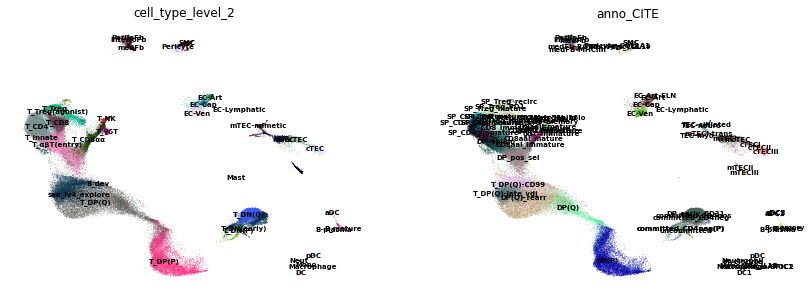

In [6]:
sc.pl.umap(gex, color = ['cell_type_level_2', 'anno_CITE'], legend_loc = "on data", 
          legend_fontsize = 7, frameon = False)

In [7]:
# gex

## Pre process IBEX

In [8]:
ibex = subset_by_anno(ibex, 'sample' , target_cells=100000)
# ibex

In [9]:
# translate the protein marker name to it's corresponding gene in the gex data  
protein_to_gene = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'CD99',
    'CD163_mean': 'CD163',
    'CD11C_mean': 'ITGAX',
    'CD8_mean': 'CD8A',
    'CD3_mean': 'CD3D',
    'CD5_mean': 'CD5',
    'CD20_mean': 'MS4A1',
    'CD34_mean': 'CD34',
    'CD7_mean': 'CD7',
    'CD31_mean': 'PECAM1',
    'CD39_mean': 'ENTPD1',
    'CD4_mean': 'CD4',
    'VA7.2_mean': 'TRAV7',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'HLA-DRB1',
    'CD123_mean': 'IL3RA',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'ITGA1',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'PTPRC',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'TCRG',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'ITGA6',
    'CD15_0_mean': None
}

# Create a new column in anndata.var for protein names
ibex.var['gene_name'] = ''
ibex.var['protein_name'] = ''

# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    protein_name = row.name
    if protein_name in protein_to_gene:
        gene_name = protein_to_gene[protein_name]
        ibex.var.loc[idx, 'gene_name'] = gene_name
        ibex.var.loc[idx, 'protein_name'] = protein_name

# Print the updated anndata.var DataFrame
print(ibex.var)

                gene_name     protein_name
nuclear_mean         None     nuclear_mean
CHGA_mean            CHGA        CHGA_mean
CD99_mean            CD99        CD99_mean
CD163_mean          CD163       CD163_mean
CD11C_mean          ITGAX       CD11C_mean
CD8_mean             CD8A         CD8_mean
CD3_mean             CD3D         CD3_mean
CD5_mean              CD5         CD5_mean
CD20_mean           MS4A1        CD20_mean
CD34_mean            CD34        CD34_mean
CD7_mean              CD7         CD7_mean
CD31_mean          PECAM1        CD31_mean
CD39_mean          ENTPD1        CD39_mean
CD4_mean              CD4         CD4_mean
VA7.2_mean          TRAV7       VA7.2_mean
TUBB3_mean          TUBB3       TUBB3_mean
CD206_mean           MRC1       CD206_mean
SPARC_mean          SPARC       SPARC_mean
LAMIN_A_mean         LMNA     LAMIN_A_mean
HLADR_mean       HLA-DRB1       HLADR_mean
CD123_mean          IL3RA       CD123_mean
DEC205_mean          LY75      DEC205_mean
AQP1_mean  

In [10]:
# Filter out non-gene features and update var_names
gene_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in protein_to_gene and protein_to_gene[feature] is not None:
        gene_features.append(feature)
        new_var_names.append(protein_to_gene[feature])

# Create a new AnnData object with gene features
ibex_gene = ibex[:, gene_features].copy()

# Update var_names in the new AnnData object
ibex_gene.var_names = new_var_names

# Print the new AnnData object
ibex_gene.var_names


Index(['CHGA', 'CD99', 'CD163', 'ITGAX', 'CD8A', 'CD3D', 'CD5', 'MS4A1',
       'CD34', 'CD7', 'PECAM1', 'ENTPD1', 'CD4', 'TRAV7', 'TUBB3', 'MRC1',
       'SPARC', 'LMNA', 'HLA-DRB1', 'IL3RA', 'LY75', 'AQP1', 'MKI67', 'AIRE',
       'ITGA1', 'KRT10', 'KRT15', 'LUM', 'LYVE1', 'VIM', 'KRT14', 'ANXA1',
       'FUT4', 'PTPRC', 'SYP', 'TCRG', 'KRT8', 'ACTA2', 'KRT5', 'FOXP3', 'DES',
       'ITGA6'],
      dtype='object')

In [11]:
# filter and batch correct ibex data 
ibex_gene = ibex_gene[ibex_gene.obs['manual_bin_cma_v2'].dropna().index]
ibex_gene.X = np.nan_to_num(ibex_gene.X, nan=0)
sc.pp.combat(ibex_gene, key='sample', inplace=True) # batch correct 
ibex_gene.X = np.nan_to_num(ibex_gene.X, nan=0)

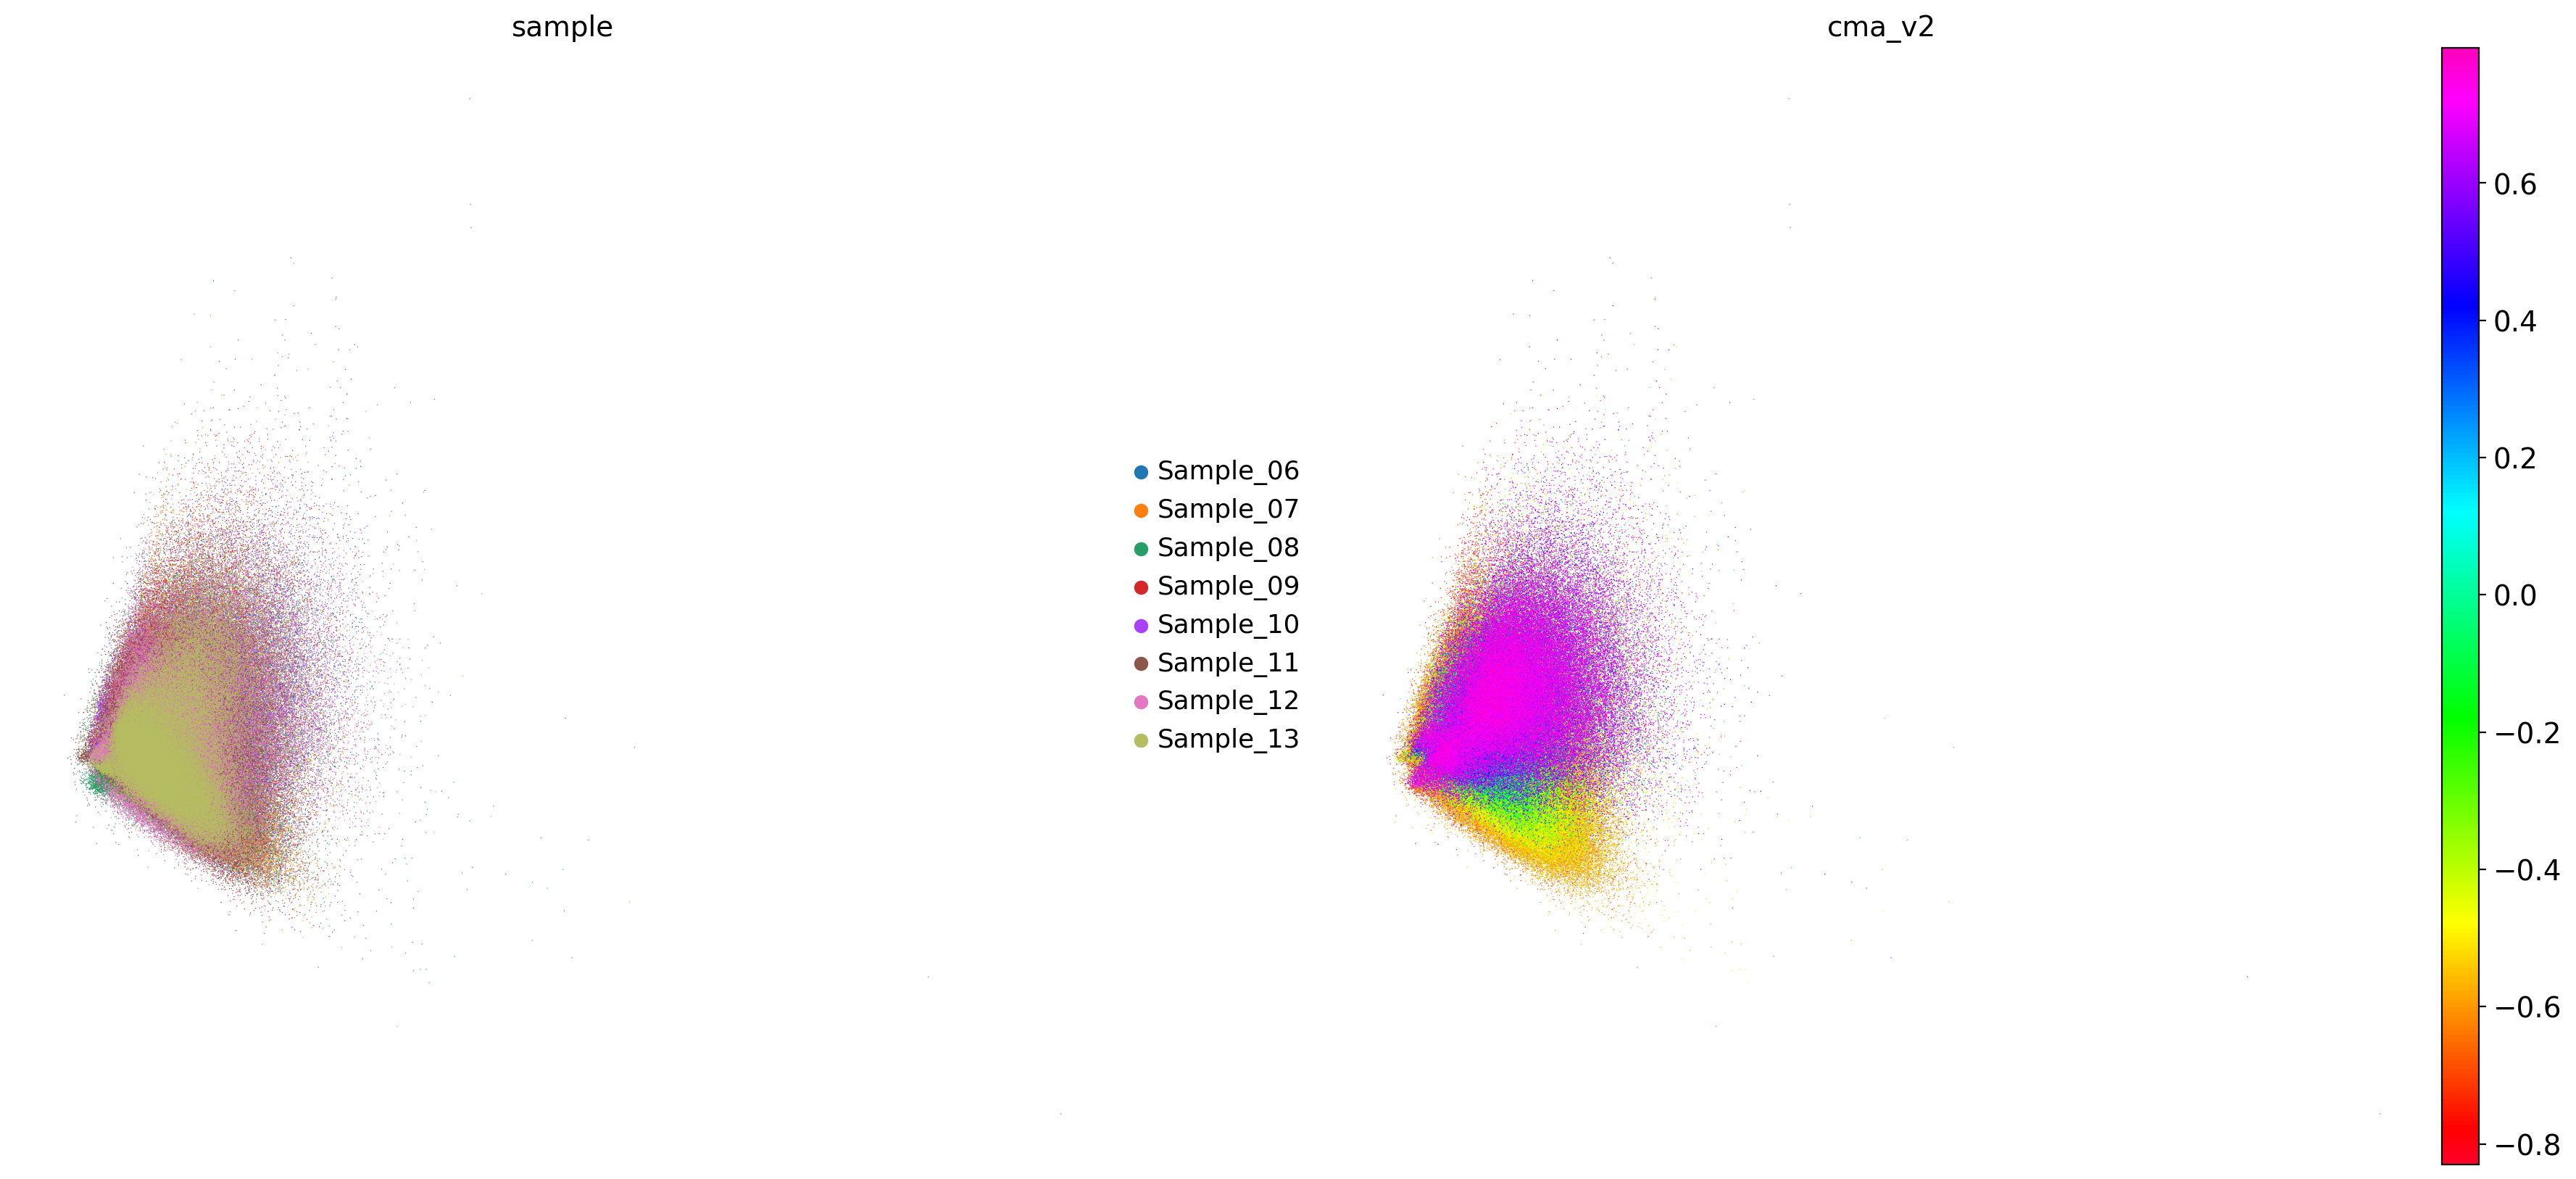

protein_name
gene_name                 
CHGA             CHGA_mean
CD99             CD99_mean
CD163           CD163_mean
ITGAX           CD11C_mean
CD8A              CD8_mean
CD3D              CD3_mean
CD5               CD5_mean
MS4A1            CD20_mean
CD34             CD34_mean
CD7               CD7_mean
PECAM1           CD31_mean
ENTPD1           CD39_mean
CD4               CD4_mean
TRAV7           VA7.2_mean
TUBB3           TUBB3_mean
MRC1            CD206_mean
SPARC           SPARC_mean
LMNA          LAMIN_A_mean
HLA-DRB1        HLADR_mean
IL3RA           CD123_mean
LY75           DEC205_mean
AQP1             AQP1_mean
MKI67            KI67_mean
AIRE             AIRE_mean
ITGA1           CD49A_mean
KRT10      KERATIN_10_mean
KRT15      KERATIN_15_mean
LUM           LUMICAN_mean
LYVE1           LYVE1_mean
VIM          VIMENTIN_mean
KRT14      KERATIN_14_mean
ANXA1        ANNEXIN1_mean
FUT4             CD15_mean
PTPRC            CD45_mean
SYP               SYP_mean
TCRG            TCRGD_mean
KRT8        KERATIN_8_mean
ACTA2            ASMA_mean
KRT5        KERATIN_5_mean
FOXP3           FOXP3_mean
DES            DESMIN_mean
ITGA6           CD49F_mean

In [12]:
# plot PCA for sanity 
sc.pp.pca(ibex_gene, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_gene,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)
ibex_gene.var['gene_name'] = ibex_gene.var['gene_name'].astype(str)
ibex_gene.var = ibex_gene.var.set_index("gene_name")
ibex_gene.var

In [13]:
# check how many genes are overlapping 
len(set(ibex_gene.var_names).intersection(gex.var_names))

41

In [14]:
os.chdir('')
gex.write_h5ad('pre_patcher_gex.h5ad')
ibex_gene.write_h5ad('pre_patcher_ibex.h5ad')
ibex.write_h5ad('pre_patcher_ibex_raw.h5ad')

# end of preprocessing 

# Step 1- Run patcher on all cells 

In [3]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 

In [4]:
os.chdir('')

In [5]:
gex = sc.read_h5ad('pre_patcher_gex.h5ad')
ibex_gene = sc.read_h5ad('pre_patcher_ibex.h5ad')

In [6]:
# ibex_gene

In [11]:
anno = 'anno_CITE'
# run patcher on individual samples without batch correctino 
import time
import scanpy as sc

In [16]:
# Get unique samples
unique_samples = ibex_gene.obs['sample'].unique()

# Dictionary to hold output for each sample
out_dict = {}

# Run the function for each sample and append the result to the list
for sample in unique_samples:
    start_time = time.time()
    # subset sample
    ibex_gene_sample = ibex_gene[ibex_gene.obs['sample'] == sample]
    # scale each sample 
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1000))
    ibex_gene_sample.X = scaler.fit_transform(ibex_gene_sample.X)
    # remove counts smaller than 1 
    # run patcher 
    out_sample = ip.patch(iss=ibex_gene_sample, gex=gex, obs_to_take=anno, computation='cKDTree', neighbours=30,obsm_fraction=True,chunk_size=200000)
    out_dict[sample] = out_sample
    end_time = time.time()
    print(f"Processed sample {sample} in {end_time - start_time} seconds")

# Concatenate all the results
out = sc.concat(out_dict, join='outer')

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_06 in 132.61137628555298 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_07 in 132.39478945732117 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_08 in 127.48134326934814 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_09 in 135.59146904945374 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_10 in 125.62875962257385 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_11 in 130.52434945106506 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_12 in 126.41728663444519 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_13 in 94.47487378120422 seconds


In [8]:
out.obs[anno] = out.obs[anno].astype('category')

def plot_cell_matrix(
    adata,
    x_anno,
    y_anno,
    x_anno_groups,
    y_anno_groups,
    figsize = [4,4],
    cmap = 'viridis',
):
    
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Group by y_anno and x_anno, then count
    cell_type_counts = adata.obs.groupby([y_anno, x_anno]).size().rename('cell_type_count').reset_index()

    # Calculate sum of counts for each y_anno group
    group_totals = cell_type_counts.groupby(x_anno)['cell_type_count'].transform('sum')

    # Divide each count by the total count of its group to get the proportion
    cell_type_counts['cell_type_frequency'] = cell_type_counts['cell_type_count'] / group_totals

    # Pivot data for heatmap
    pivot_df_cell_type = cell_type_counts.pivot(index=x_anno, columns=y_anno, values='cell_type_frequency')

    # Reorder the clusters
    pivot_df_cell_type = pivot_df_cell_type.reindex(x_anno_groups)
    pivot_df_cell_type = pivot_df_cell_type.reindex(index=x_anno_groups, columns=y_anno_groups)
    pivot_df_cell_type_plot = pivot_df_cell_type.loc[:,y_anno_groups]
    pivot_df_cell_type_plot = pivot_df_cell_type_plot.div(pivot_df_cell_type_plot.max(axis=0), axis=1)

    # Calculate the number of unique categories in x_anno and y_anno
    n_x_anno = len(adata.obs[x_anno].unique())
    n_y_anno = len(adata.obs[y_anno].unique())

    # Set the plot size to be proportional to the number of categories
    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap
    sns.heatmap(pivot_df_cell_type_plot, cmap=cmap)

    ax.set_title('Cell Type Normalized Frequencies')
    ax.grid(False)  # This will remove gridlines

    plt.tight_layout()
    plt.show()  

In [9]:
def plot_cell_dotplot(
    adata,
    x_anno,
    y_anno,
    x_anno_groups,
    y_anno_groups,
    figsize=[4, 4],
    cmap='viridis',
    save_name=None,
    source_export = ""
):

    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # Group by y_anno and x_anno, then count
    cell_type_counts = adata.obs.groupby([y_anno, x_anno]).size().rename('cell_type_count').reset_index()

    # Calculate sum of counts for each y_anno group
    group_totals = cell_type_counts.groupby(x_anno)['cell_type_count'].transform('sum')

    # Divide each count by the total count of its group to get the proportion
    cell_type_counts['cell_type_frequency'] = cell_type_counts['cell_type_count'] / group_totals

    # Pivot data for dot plot
    pivot_df_cell_type = cell_type_counts.pivot(index=x_anno, columns=y_anno, values='cell_type_frequency')

    # Reorder the clusters
    pivot_df_cell_type = pivot_df_cell_type.reindex(x_anno_groups)
    pivot_df_cell_type = pivot_df_cell_type.reindex(index=x_anno_groups, columns=y_anno_groups)

    # Get the max value for size normalization across the entire dataset
    max_size_value = pivot_df_cell_type.max().max()

    n_x_anno = len(x_anno_groups)
    n_y_anno = len(y_anno_groups)

    fig, ax = plt.subplots(figsize=figsize)

    for j in range(n_y_anno):
        # Normalize color based on the maximum value in each y_anno group
        max_color_value = pivot_df_cell_type.iloc[:, j].max()
        norm_color = mcolors.Normalize(vmin=0, vmax=max_color_value)
        cmap_color = cm.get_cmap(cmap)

        for i in range(n_x_anno):
            x_val = j
            y_val = i
            size = pivot_df_cell_type.iloc[i, j]
            if pd.notna(size):  # Ensure that the value is not NaN
                normalized_size = size / max_size_value
                ax.scatter(x_val, y_val, s=normalized_size * 500, c=[cmap_color(norm_color(size))])

    ax.set_title('Cell Type Normalized Frequencies')
    ax.set_xticks(range(n_y_anno))
    ax.set_yticks(range(n_x_anno))
    ax.set_xticklabels(y_anno_groups, rotation=90) # Rotate the x-labels
    ax.set_yticklabels(x_anno_groups)

    # Add space between the extreme values along the x-axis
    plt.xlim(-1, n_y_anno)

    # Remove grid
    ax.grid(False)

    # Invert the y-axis to display the categories in the desired order
    ax.invert_yaxis()

    plt.tight_layout()

    # Save the figure if save_name is specified
    if save_name:
        plt.savefig(save_name)
    
  #  if source_export:
        
    plt.show()
    return(pivot_df_cell_type)

In [8]:
os.chdir('')
import imagespot_rev_v1 as ims

In [7]:
os.chdir('')
out = sc.read_h5ad('out_RNA_1m_KNN30_v3.h5ad')

In [13]:
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
out.obs = ims.bin_axis(ct_order ,ct2_values,out.obs,'cma_v2')   
out.obs.loc[out.obs['annotation_lv_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
out.obs['manual_bin_cma_v2'].value_counts()


Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level 1= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level 2= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level 3= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level 1= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level 2= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level 3= (0.7=<cma_v2)


Cortical level 1    222524
Cortical level 2    154972
Sub-Capsular        109138
Cortical level 3     70208
Capsular             47818
Cortical CMJ         45049
Medullar CMJ         35639
Medullar level 3     31844
Medullar level 1     27340
Medullar level 2     19916
Name: manual_bin_cma_v2, dtype: int64

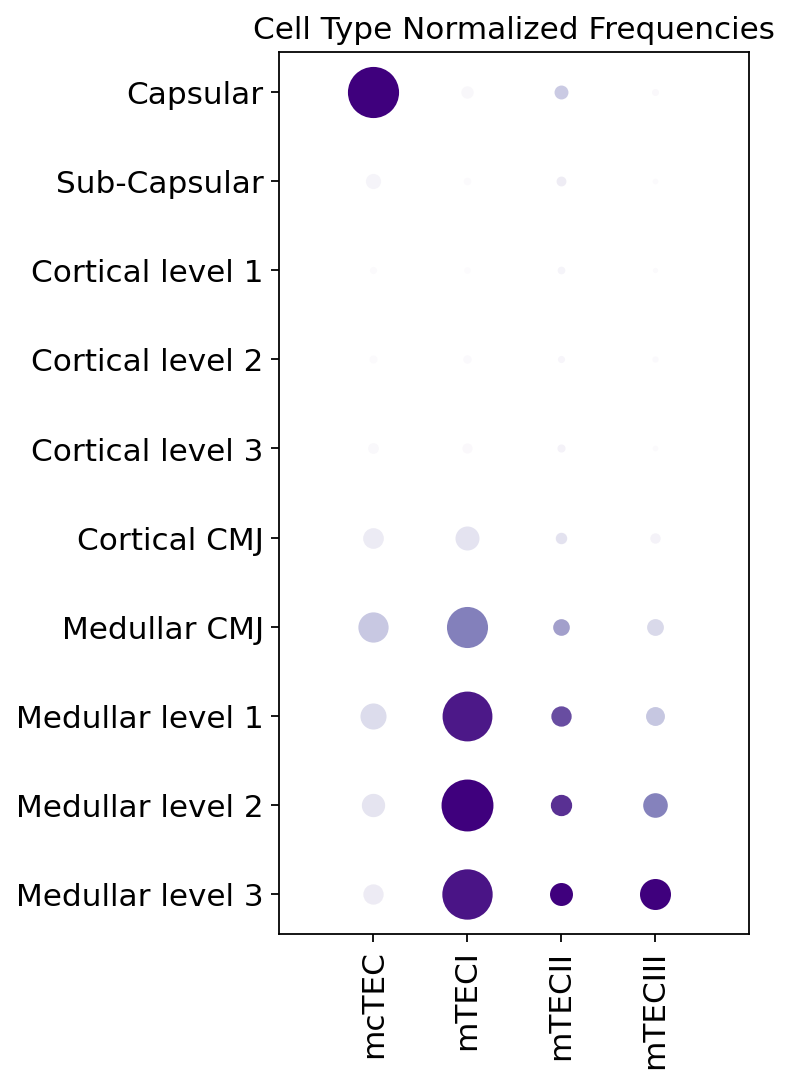

In [12]:
sc.set_figure_params(figsize=[5,5])
cells = ['mcTEC','mTECI','mTECII','mTECIII']
fraction = 0.85
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[5,7],cmap='Purples',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/mTECs_f'+str(fraction)+'_IBEX_impute.pdf')

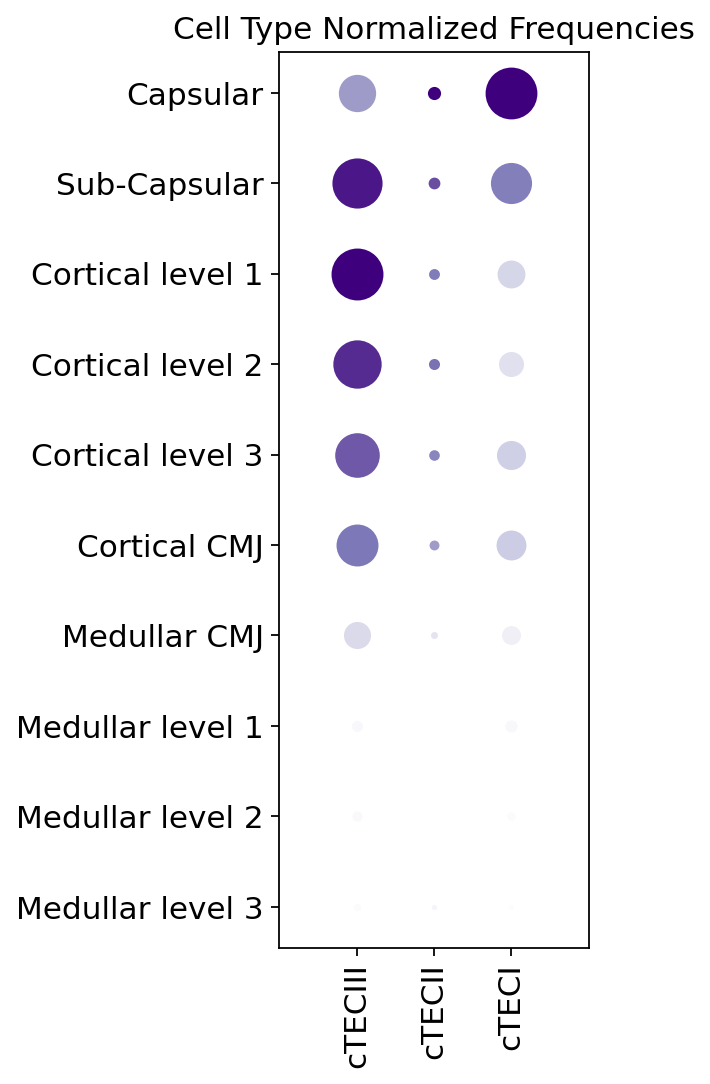

In [13]:
cells = ['cTECIII','cTECII','cTECI']
fraction = 0.45
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[4,7],cmap='Purples',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/cTECs_f'+str(fraction)+'_IBEX_impute.pdf')

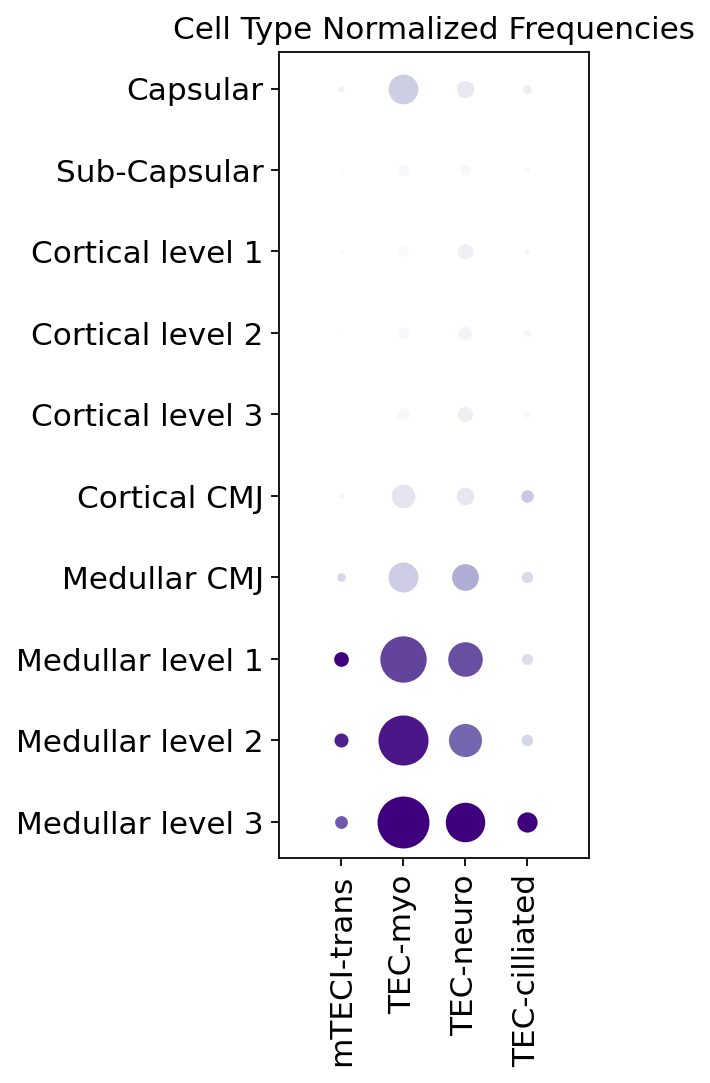

In [15]:
# special Tecs 
cells = ['mTECI-trans','TEC-myo','TEC-neuro','TEC-cilliated']
fraction = 0.3
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[4,7],cmap='Purples',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/cTECs_special_f'+str(fraction)+'_IBEX_impute.pdf')

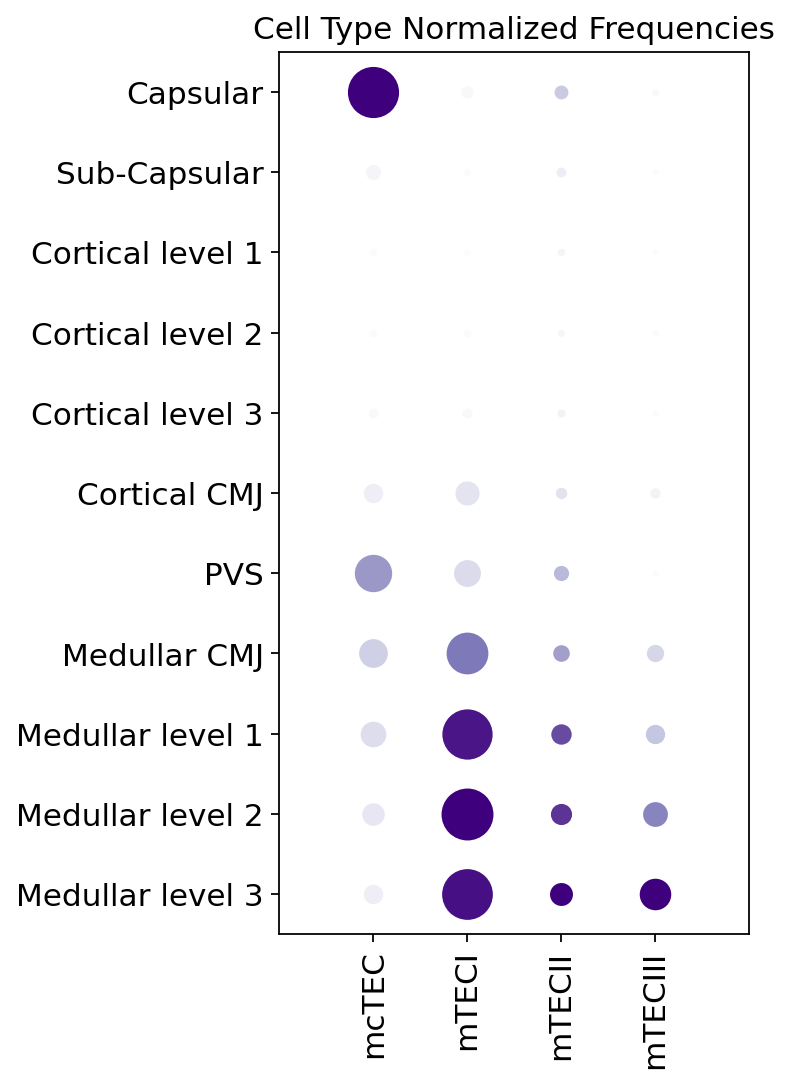

In [17]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/')
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].astype('string')
out.obs.loc[out.obs['annotation_lv_1']=='PVS','manual_bin_cma_v2'] = 'PVS'
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].astype('category')
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','PVS','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
sc.set_figure_params(figsize=[5,5])
cells = ['mcTEC','mTECI','mTECII','mTECIII']
fraction = 0.85
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[5,7],cmap='Purples',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/mTECs_PVS_f'+str(fraction)+'_IBEX_impute.pdf')

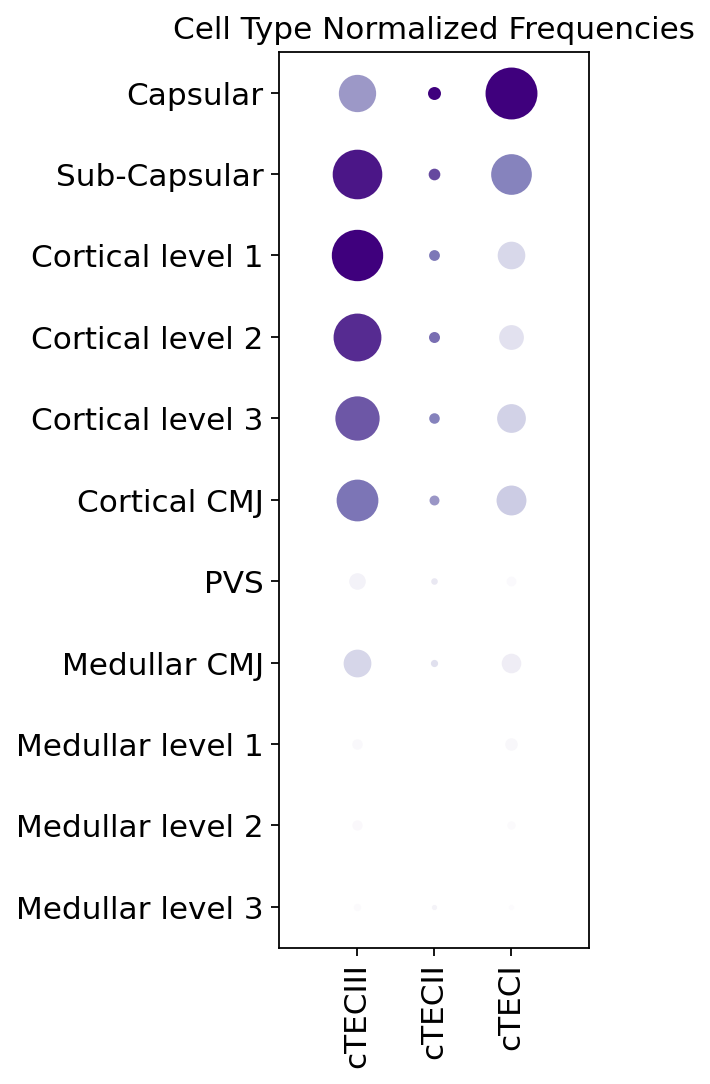

In [18]:
cells = ['cTECIII','cTECII','cTECI']
fraction = 0.45
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[4,7],cmap='Purples',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/cTECs_PVS_f'+str(fraction)+'_IBEX_impute.pdf')

In [18]:
# plot expression of genes 

In [20]:
ibex_gene.obs['anno_CITE']  = out.obs['anno_CITE']

In [17]:
ibex_gene

AnnData object with n_obs × n_vars = 764448 × 42
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'protein_name'
    uns: 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [ ]:
sc.pl.dotplot(anno_CITE,)


# plot  
# del adata_tmp
import numpy as np
anno = 'cell_type_level_1'
cells = ['B', 'DC', 'EC', 'Fb', 'Macrophage', 'Mast', 'Mesothelium', 'Mono',
       'Myeloid_progenitor', 'Schwann', 'TEC',
       'TEC-mimetic', 'T_CD4', 'T_CD8', 'T_DN', 'T_DN(early)', 'T_DP',
       'T_NK', 'T_Treg', 'T_innate', 'T_αβT(entry)', 'Vascular',]

genes = diff_genes['Gene']
adata_tmp = adata.copy()

# subset to cells and generate new category for plotting 
adata_tmp.obs[anno] = pd.Categorical(adata_tmp.obs[anno], categories=cells, ordered=True)
adata_tmp = adata_tmp[~adata_tmp.obs[anno].isna()]
groupby = [anno,'age_group']       
adata_tmp.obs['groupby_combined'] = adata_tmp.obs[groupby].astype(str).apply('_'.join, axis=1)

# Filter for groups with at least 50 cells
group_sizes = adata_tmp.obs.groupby('groupby_combined').size()
groups_to_keep = group_sizes[group_sizes >= 50].index
adata_tmp = adata_tmp[adata_tmp.obs['groupby_combined'].isin(groups_to_keep)]

# plotting 
fig = sc.pl.dotplot(adata_tmp,
                    var_names=genes,
#                     swap_axes=True,
                    groupby='groupby_combined',
                    standard_scale='var',
                    return_fig=True,)

In [7]:
# save output 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/')
# out.write_h5ad('out_RNA_1m_KNN30_v3.h5ad')
out = sc.read_h5ad('out_RNA_1m_KNN30_v3.h5ad')

# Step 2 - keep only T cells and map to CITEseq data and RNA data again 

In [1]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
os.chdir('')

In [14]:
anno = 'anno_CITE'
gex = sc.read_h5ad('pre_patcher_gex.h5ad')
gex.obs.index = gex.obs.index.str.split('-').str[:2].str.join('-')
ibex = sc.read_h5ad('pre_patcher_ibex_raw.h5ad')
out = sc.read_h5ad('out_RNA_1m_KNN30_v3.h5ad')

In [21]:
# gex.obs_names

In [17]:
ibex

AnnData object with n_obs × n_vars = 764448 × 45
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'gene_name', 'protein_name'
    layers: 'counts'

In [18]:
gex_new = sc.read("") # load most recent atlas object 

In [28]:
gex.obsm['protein_expression'] = gex_new.obsm['protein_expression'].loc[gex.obs_names]

In [31]:
def extract_cite_adata(data , protein_key = 'protein_expression'):
    import anndata as ad 
    import scipy.sparse as sp
    protein_data = sp.csr_matrix(data.obsm[protein_key])
    var_cite = pd.DataFrame(
        data = np.hstack((np.zeros(len(data.var), dtype=bool) , np.ones((protein_data.shape[1]), dtype=bool))),
        index = data.var_names.to_list() + data.obsm[protein_key].columns.to_list(),columns=['cite'],
    )
    var_cite.columns = "cite_" + var_cite.columns

    adata_cite = ad.AnnData(
        X=sp.hstack([data.X, protein_data]),
        obs=data.obs,
        obsm = data.obsm,
        uns=data.uns,
        var=var_cite,
    )
    return adata_cite

gex_cite = extract_cite_adata(data = gex, protein_key = 'protein_expression')

/tmp/ipykernel_38930/124504893.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_cite = ad.AnnData(


In [32]:
pd.set_option('display.max_rows', 200)
# gex_cite.obs.anno_CITE.value_counts()

In [33]:
ibex_to_cite = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'cite_CD99',
    'CD163_mean': 'cite_CD163',
    'CD11C_mean': 'cite_CD11c',
    'CD8_mean': 'cite_CD8',
    'CD3_mean': 'cite_CD3',
    'CD5_mean': 'cite_CD5',
    'CD20_mean': 'cite_CD20',
    'CD34_mean': 'cite_CD34',
    'CD7_mean': 'cite_CD7',
    'CD31_mean': 'cite_CD31',
    'CD39_mean': 'cite_CD39',
    'CD4_mean': 'cite_CD4',
    'VA7.2_mean': 'cite_TCR-Va7.2',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'cite_HLA-DR',
    'CD123_mean': 'cite_CD123',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'cite_CD49a',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'cite_CD45',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'cite_TCRgd',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'cite_CD49f',
    'CD15_0_mean': None
}

# translate the protein marker name to it's corresponding gene in the gex data  
ibex_to_rna = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'CD99',
    'CD163_mean': 'CD163',
    'CD11C_mean': 'ITGAX',
    'CD8_mean': 'CD8A',
    'CD3_mean': 'CD3D',
    'CD5_mean': 'CD5',
    'CD20_mean': 'MS4A1',
    'CD34_mean': 'CD34',
    'CD7_mean': 'CD7',
    'CD31_mean': 'PECAM1',
    'CD39_mean': 'ENTPD1',
    'CD4_mean': 'CD4',
    'VA7.2_mean': 'TRAV7',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'HLA-DRB1',
    'CD123_mean': 'IL3RA',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'ITGA1',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'PTPRC',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'TCRG',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'ITGA6',
    'CD15_0_mean': None
}


# Create a new column in anndata.var for protein names
ibex.var['cite_name'] = ''
ibex.var['rna_name'] = ''
ibex.var['ibex_name'] = ''

In [34]:
# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    ibex_name = row.name
    if ibex_name in ibex_to_cite:
        cite_name = ibex_to_cite[ibex_name]
        ibex.var.loc[idx, 'cite_name'] = cite_name
        
# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    ibex_name = row.name
    if ibex_name in ibex_to_rna:
        rna_name = ibex_to_rna[ibex_name]
        ibex.var.loc[idx, 'rna_name'] = rna_name
        ibex.var.loc[idx, 'ibex_name'] = ibex_name
        
# Print the updated anndata.var DataFrame
print(ibex.var)

                gene_name     protein_name       cite_name  rna_name  \
nuclear_mean          NaN     nuclear_mean            None      None   
CHGA_mean            CHGA        CHGA_mean            CHGA      CHGA   
CD99_mean            CD99        CD99_mean       cite_CD99      CD99   
CD163_mean          CD163       CD163_mean      cite_CD163     CD163   
CD11C_mean          ITGAX       CD11C_mean      cite_CD11c     ITGAX   
CD8_mean             CD8A         CD8_mean        cite_CD8      CD8A   
CD3_mean             CD3D         CD3_mean        cite_CD3      CD3D   
CD5_mean              CD5         CD5_mean        cite_CD5       CD5   
CD20_mean           MS4A1        CD20_mean       cite_CD20     MS4A1   
CD34_mean            CD34        CD34_mean       cite_CD34      CD34   
CD7_mean              CD7         CD7_mean        cite_CD7       CD7   
CD31_mean          PECAM1        CD31_mean       cite_CD31    PECAM1   
CD39_mean          ENTPD1        CD39_mean       cite_CD39    EN

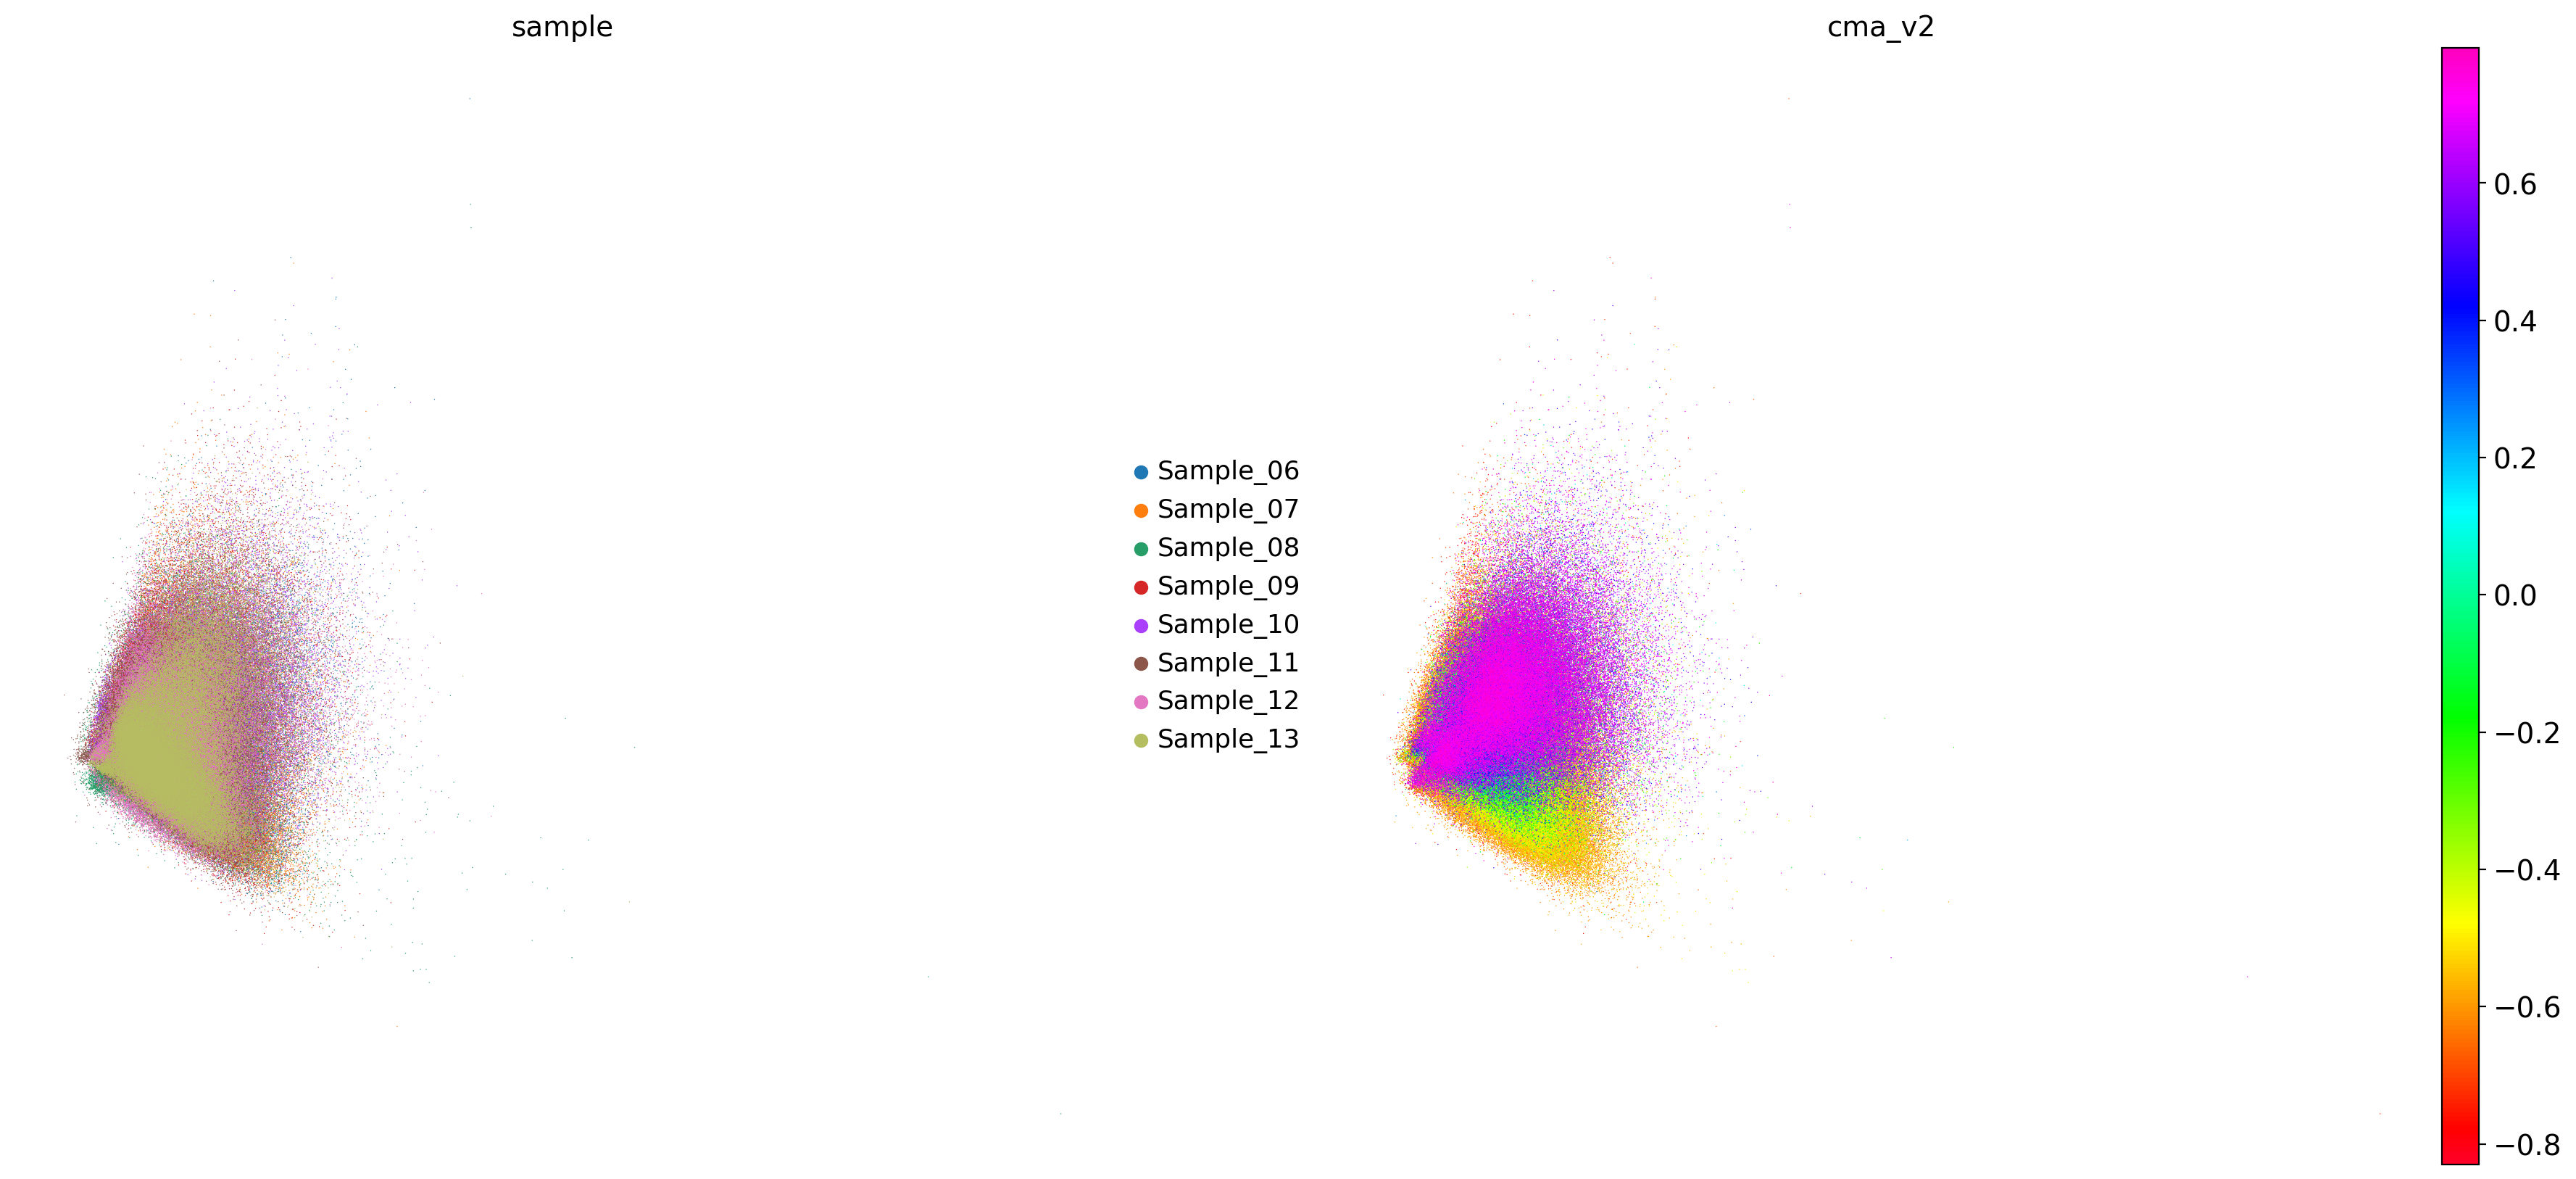

AnnData object with n_obs × n_vars = 764448 × 42
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'gene_name', 'protein_name', 'cite_name', 'rna_name', 'ibex_name'
    uns: 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [35]:
# Filter out non-cite features and update var_names
cite_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in ibex_to_cite and ibex_to_cite[feature] is not None:
        cite_features.append(feature)
        new_var_names.append(ibex_to_cite[feature])

# Create a new AnnData object with gene features
ibex_cite = ibex[:, cite_features].copy()

# Update var_names in the new AnnData object
ibex_cite.var_names = new_var_names

# Print the new AnnData object
ibex_cite = ibex_cite[ibex_cite.obs['manual_bin_cma_v2'].dropna().index]
ibex_cite.X = np.nan_to_num(ibex_cite.X, nan=0)
sc.pp.combat(ibex_cite, key='sample', inplace=True) # batch correct 
ibex_cite.X = np.nan_to_num(ibex_cite.X, nan=0)
ibex_cite.var_names
sc.pp.pca(ibex_cite, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_cite,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)
ibex_cite

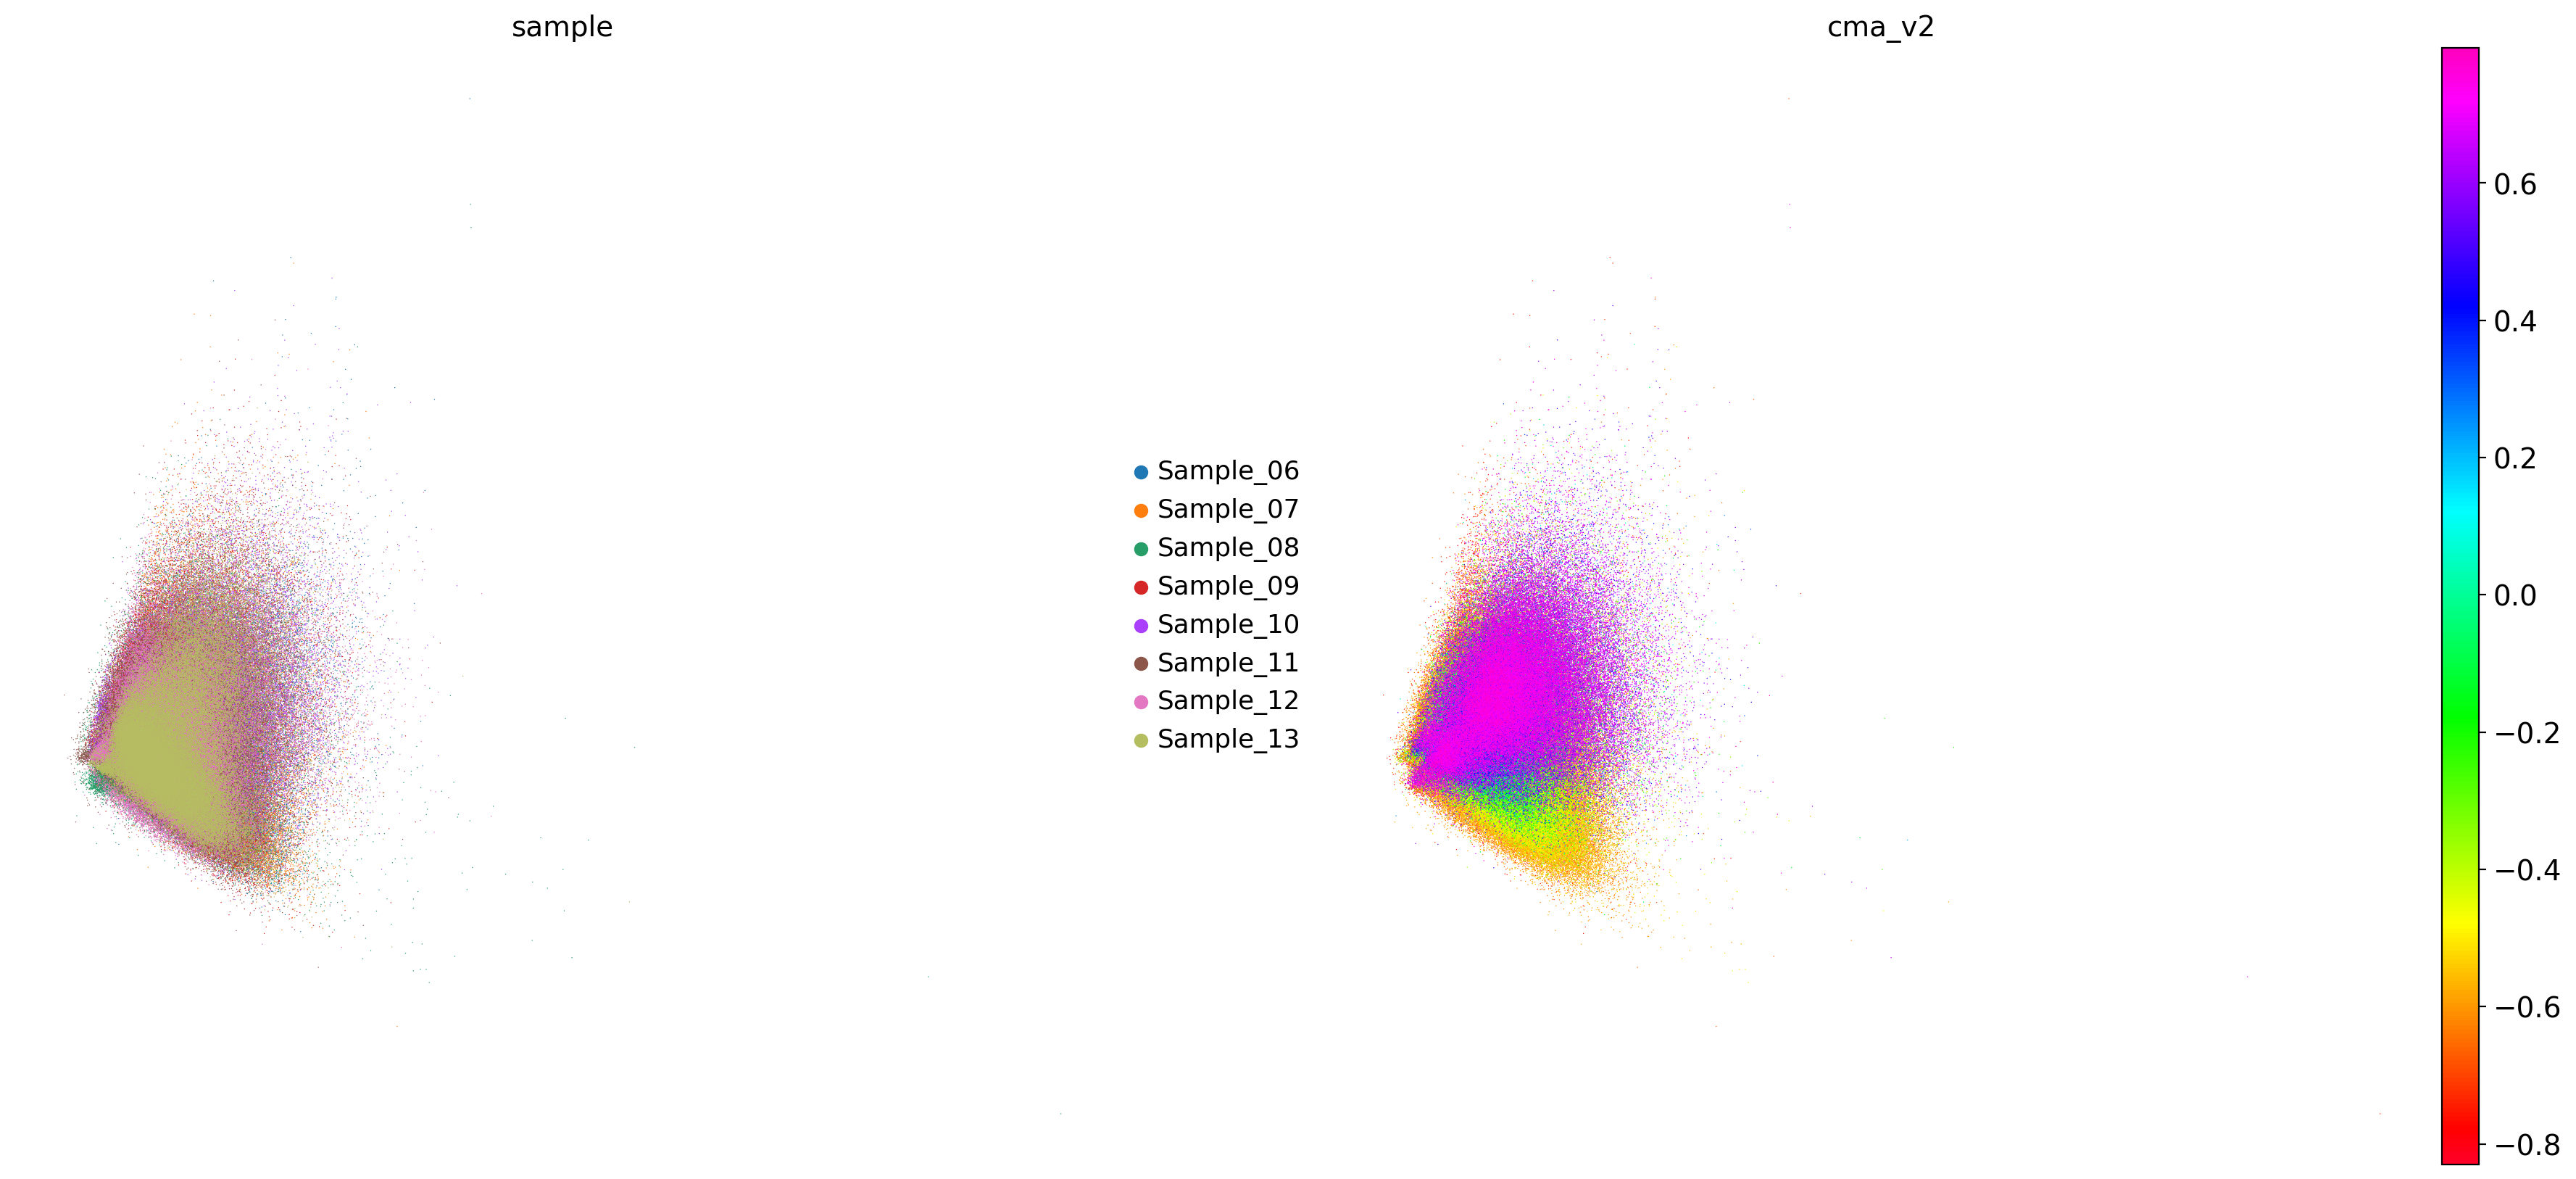

AnnData object with n_obs × n_vars = 764448 × 42
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'gene_name', 'protein_name', 'cite_name', 'rna_name', 'ibex_name'
    uns: 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [36]:
# Filter out non-rna features and update var_names
rna_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in ibex_to_rna and ibex_to_rna[feature] is not None:
        rna_features.append(feature)
        new_var_names.append(ibex_to_rna[feature])

# Create a new AnnData object with gene features
ibex_rna = ibex[:, rna_features].copy()

# Update var_names in the new AnnData object
ibex_rna.var_names = new_var_names

# Print the new AnnData object
ibex_rna = ibex_rna[ibex_rna.obs['manual_bin_cma_v2'].dropna().index]
ibex_rna.X = np.nan_to_num(ibex_rna.X, nan=0)
sc.pp.combat(ibex_rna, key='sample', inplace=True) # batch correct 
ibex_rna.X = np.nan_to_num(ibex_rna.X, nan=0)
ibex_rna.var_names
sc.pp.pca(ibex_rna, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_rna,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)
ibex_rna

In [37]:
out.obs[anno].cat.categories

Index(['B-memory', 'B-naive', 'B-plasma', 'CD8aaII_immature', 'CD8aaII_mature',
       'CD8aaI_immature', 'CD8aaI_mature', 'DC1', 'DC2', 'DP(P)', 'DP(Q)',
       'DP(Q)_rearr', 'DP_4hi8lo', 'DP_early_CD31', 'DP_pos_sel', 'EC-Art',
       'EC-Art-ELN', 'EC-Cap', 'EC-Lymphatic', 'EC-Ven', 'InterloFb',
       'Macrophage-APOC2', 'Macrophage-SPIC1', 'Monocyte_IL1B', 'NKT_dev',
       'NK_circ_56hi16lo', 'NK_tr_itg_hi', 'NK_tr_itg_lo', 'Neutrophil',
       'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'SMC',
       'SP_CD4_immature', 'SP_CD4_mature', 'SP_CD4_semimature',
       'SP_CD8_immature', 'SP_CD8_mature', 'SP_CD8_memory',
       'SP_CD8_semimature', 'SP_Treg_CD8', 'SP_Treg_PD1', 'SP_Treg_immature',
       'SP_Treg_mature', 'SP_Treg_recirc', 'TEC-cilliated', 'TEC-myo',
       'TEC-neuro', 'T_DP(Q)-CD99', 'T_DP(Q)-late_vdj', 'aDC1', 'aDC2', 'aDC3',
       'cTECI', 'cTECII', 'cTECIII', 'committed_CD4neg', 'committed_CD4neg(P)',
       'committed_CD4pos', 'committed_CD4po

In [39]:
keep = ['B-memory', 'B-naive', 'B-plasma','CD8aaII_immature', 'CD8aaII_mature',
       'CD8aaI_immature', 'CD8aaI_mature', 'DP(P)', 'DP(Q)',
       'DP(Q)_rearr', 'DP_4hi8lo', 'DP_early_CD31', 'DP_pos_sel', 
       'NK_circ_56hi16lo', 'NK_tr_itg_hi', 'NK_tr_itg_lo', 
       'SP_CD4_immature', 'SP_CD4_mature', 'SP_CD4_semimature',
       'SP_CD8_immature', 'SP_CD8_mature', 'SP_CD8_memory',
       'SP_CD8_semimature', 'SP_Treg_CD8', 'SP_Treg_PD1', 'SP_Treg_immature',
       'SP_Treg_mature', 'SP_Treg_recirc', 'T_DP(Q)-CD99', 'T_DP(Q)-late_vdj',
       'committed_CD4neg', 'committed_CD4neg(P)',
       'committed_CD4pos', 'committed_CD4pos(P)', 'gdT_Vd2', 'gdT_immature',
       'gdT_mature', 'gdT_semimature', 
       'uncommitted']

In [41]:
# keep only T cells in cite object 
ibex_cite = ibex_cite[out.obs[anno].isin(keep)]
# print(len(set(ibex_cite.var_names).intersection(gex_cite.var_names)))
# print(ibex_cite)

## save prepatcher object 


In [43]:
os.chdir('')
gex_cite.write_h5ad('pre_patcher_gex_T_only.h5ad')
ibex_cite.write_h5ad('pre_patcher_ibex_cite_T_only.h5ad')
ibex_rna.write_h5ad('pre_patcher_ibex_rna_T_only.h5ad')


# Step 3 -  load from scratch and run patcher on RNA and then on cite 

In [64]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
anno = 'anno_CITE'
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/')
gex_cite = sc.read_h5ad('pre_patcher_gex_T_only.h5ad')

In [74]:
# len(np.where(gex_cite.obs['cite'])[0])

In [79]:
adata_filtered = gex_cite[:, gex_cite.var['cite_cite']].copy()
gex_cite = gex_cite[adata_filtered.X.sum(axis=1) > 0]

In [80]:
# gex_cite

In [82]:
gex_cite = gex_cite[gex_cite.obs['study'] == 'HTSA_Ghent'] # make sure there are no cells witout citeseq data 
gex_cite

View of AnnData object with n_obs × n_vars = 78246 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry_simple', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'path_cellbender_gex', 'study', 'study_group', 'sample', 'enrichment', 'donor', 'cite', 'sex', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'backup_barcode', 'louvian_05', 'leiden_05', 'leiden_1', 'leiden_2', 'park_2020_cell_type', 'panfetal_2022_cell_type', 'cell_type_level_4', 'cell_type_level_3', 'cell_type_level_2', 'cell_type_level_1', 'cell_type_level_0', 'pseudotime_nhood_vdj', 'prob_CD8+T_nhood_vdj', 'prob_CD4+T_nhood_vdj', 'leiden_3', 'leiden_4', 'unannotated', 'pred_cell_type_level_4', 'pred_cell_type_level_4_uncertainties', 'undefined', 'RNA.weight', 'ADTdsb.weight', 'low_ADT', 'spt_CD4', 'spt_CD8', 'anno_C

In [83]:
columns_containing_spt = [col for col in gex_cite.obs.columns if 'spt' in col]
columns_containing_spt

['spt_CD4', 'spt_CD8']

In [86]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_6_nat/')
gex_cite.write_h5ad('pre_patcher_gex_cite_T_only_clean.h5ad')

# run patcher on RNA/cite

In [1]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
anno = 'anno_CITE'
os.chdir('')
ibex_cite = sc.read_h5ad('pre_patcher_ibex_cite_T_only.h5ad')
os.chdir('')
gex_cite = sc.read_h5ad('pre_patcher_gex_cite_T_only_clean.h5ad')
columns_containing_spt = [col for col in gex_cite.obs.columns if 'spt' in col]
columns_containing_spt

['spt_CD4', 'spt_CD8']

In [4]:
gex_cite.X.data = np.round(gex_cite.X.data)

In [5]:
# run patcher on individual samples without batch correctino 
import time
import scanpy as sc

# Get unique samples
unique_samples = ibex_cite.obs['sample'].unique()

# Dictionary to hold output for each sample
out_dict = {}

# Run the function for each sample and append the result to the list
for sample in unique_samples:
    # if sample == 'Sample_06':
        start_time = time.time()
        # subset sample
        ibex_cite_sample = ibex_cite[ibex_cite.obs['sample'] == sample]
        # scale each sample 
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1000))
        ibex_cite_sample.X = scaler.fit_transform(ibex_cite_sample.X)
        # remove counts smaller than 10 
        mask = ibex_cite_sample.X < 7
        ibex_cite_sample.X[mask] = 0
        # run patcher 
        out_sample = ip.patch(
            iss=ibex_cite_sample,
            gex=gex_cite,
            obs_to_take=[anno, 'cell_type_level_4_explore'],
            cont_obs_to_take=columns_containing_spt,
            computation='cKDTree',
            neighbours=7,
            chunk_size=100000,
        )
        out_dict[sample] = out_sample
        end_time = time.time()
        print(f"Processed sample {sample} in {end_time - start_time} seconds")

/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_06 in 243.3779969215393 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_07 in 266.8558621406555 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_08 in 245.3239061832428 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_09 in 239.430739402771 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_10 in 229.57628417015076 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_11 in 235.45362067222595 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_12 in 242.38569355010986 seconds


/tmp/ipykernel_13584/1935382663.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_13 in 165.82357001304626 seconds


In [6]:
# Concatenate all the results
out_cite = sc.concat(out_dict, join='outer')

In [8]:
out_cite.obs['cma_v2_exp2'] = np.exp2(out_cite.obs['cma_v2']-0.16)-1


In [16]:
os.chdir('')
# del out_cite.obsm
out_cite.obs.to_csv('out_cite_ibex_cite_T_only_th_7_KNN7_psudo_v2.csv')
